# Pipeline do processamento

In [28]:
# Preâmbulo 

if False: 
    !pip install nilearn       =0.5.0             
    !pip install nibabel       =2.3.3  
    !pip install scipy         =1.1.0
    !pip install deepbrain     =0.1     
    !pip install numpy         =1.15.1
    !pip install matplotlib    =2.3.3
    !pip install pandas        =0.23.4
    !pip install opencv-python =3.4.3

from nilearn           import plotting
from deepbrain         import Extractor
from skimage.transform import resize
from scipy             import ndimage
from scipy.signal      import find_peaks, medfilt

import nibabel           as nib
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import cv2
import imageio
import PIL

plt.rcParams.update({'font.size': 18})

print("All packages loaded")

All packages loaded


## Funções auxiliares para carregar arquivos e plotar imagens

A primeira parte do projeto consiste em aplicar um pré processamento nas imagens. Para isso, vamos criar algumas funções auxiliares:

| Função | Descrição |
|---|---|
| <pre>load\_nii(path\_file)</pre> | Essa função recebe um caminho para um arquivo e faz a leitura dele, aplicando uma rotação e normalização para o intervalo [0, 255], e então retorna tanto a imagem 'crua' quanto a imagem que foi rotacionada e normalizada |
|<pre>plot\_bolacha(img, bolachas=10, title=None)</pre> | Recebe uma imagem (pode ter sido pré processada ou não, o único requisito é ter 3 dimensões), o número de bolachas (fatias que serão plotadas em cada corte anatômico (axial, coronal e sagital), e um título opcional para ser colocado na imagem|
|<pre>create\_gif(sub, sub\_white, sub\_gray, sub\_csf, fname='data', duration=0.05)</pre> | Recebe 4 imagens com 3 dimensões, a primeira sendo a imagem 'crua', a segunda a imagem com massa branca segmentada, a terceira com massa cinza segmentada, e a quarta com o líquor segmentado. O parâmetro fname serve para nomear o gif que será salvo. Para a criação do gif, todas as imagens vão ser redimensionadas em um quadrado com o tamanho do lado sendo o menor tamanho entre todas as dimensões de todas as imagens, então as imagens serão concatenadas e um gif com todas as imagens sendo percorridas em todos os cortes anatômicos será criado |

In [29]:

def load_nii(path_file):
    
    img_raw = nib.load(path_file).get_fdata()
    img_np  = ndimage.rotate(img_raw, 90, axes=(0, 2), reshape=False)
    img_np  = 255*(img_np - np.min(img_np))/np.ptp(img_np)

    return img_np, img_raw


def plot_bolacha(img, bolachas=10, title=None):
    
    x_len, y_len, z_len = img.shape
    x_step, y_step, z_step = x_len/bolachas, y_len/bolachas, z_len/bolachas
    
    fig, axs = plt.subplots(nrows=3, ncols=bolachas, figsize=(3*bolachas,5), facecolor='black')

    # Desconsidera o começo e o final extremos da imagem
    for i, (x, y, z) in enumerate(zip(
        np.linspace(x_step, x_len-x_step, bolachas), 
        np.linspace(y_step, y_len-y_step, bolachas),
        np.linspace(z_step, z_len-z_step, bolachas)
    )):

        axs[0][i].imshow(img[int(x),:,:], 'gray')
        axs[0][i].set_xticklabels([])
        axs[0][i].set_yticklabels([])
        
        axs[1][i].imshow(img[:,int(y),:], 'gray')
        axs[1][i].set_xticklabels([])
        axs[1][i].set_yticklabels([])
        
        axs[2][i].imshow(img[:,:,int(z)], 'gray')
        axs[2][i].set_xticklabels([])
        axs[2][i].set_yticklabels([])
        
    if title is not None:
        plt.suptitle(title, color='white')
        
    axs[0][0].set_ylabel('Axial', color='white')
    axs[1][0].set_ylabel('Coronal', color='white')
    axs[2][0].set_ylabel('Sagital', color='white')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.9])

    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    

def create_gif(sub, sub_white, sub_gray, sub_csf, fname='data', duration=0.05):
    
    min_size = np.min([s.shape for s in [sub, sub_white, sub_gray, sub_csf]])
    subs = []
    
    for s in [sub, sub_white, sub_gray, sub_csf]:
        s = np.copy(s)
        s = resize(s, (min_size, min_size, min_size), mode='constant', anti_aliasing=True)
        s = 255*((s - np.min(s))/np.ptp(s))
        s = s.astype('uint8')
        subs.append(s)

    images = []
    for bolacha in range(min_size):
        frame = []
        for s in subs:
            frame.append(np.hstack( (s[bolacha,:,:], s[:,bolacha,:], s[:,:,bolacha]) ))
            
        imgs_comb = np.vstack( (frame[0], frame[1], frame[2], frame[3]) )
        images.append(imgs_comb)
        
    output_file = f'{fname}.gif'
    imageio.mimsave(output_file, images, duration=duration)

## Funções auxiliares para o pré processamento

Aqui vamos criar algumas funções que serão úteis para explorar a questão da segmentação.

| Função | Descrição |
| --- | --- |
| <pre>\_get\_minmax(img, axis=0)</pre> | Função que recebe uma imagem e um eixo, e percorre todas as fatias no sentido do eixo buscando encontrar todas as que são fatias nulas (todos os elementos são 0), e então determinar os limites naquele eixo em que a imagem não é nula |
| <pre>\_get\_edges(img)</pre>| Recebe uma imagem e aplica a função anterior em todos os eixos, encontrando as coordenadas da imagem de ressonância (3D) que possuem o cérebro |
| <pre>cut\_on\_edges(img)</pre> | Recebe uma imagem, e utilizando as coordenadas encontradas pela função anterior, corta todas as fatias ao longo dos 3 eixos onde todos os elementos são zero |
| <pre>myhist(img)</pre> | Recebe uma imagem n-dimensional e, assumindo que a imagem só possua uma banda e os valores estão no intervalo discreto de $[0, 255]$, essa função calcula o histograma da imagem inteira |

In [3]:
def _get_minmax(img, axis=0):
    x_len = len(img[:, 0, 0])
    y_len = len(img[0, :, 0])
    z_len = len(img[0, 0, :])
    
    axis_lens = [x_len, y_len, z_len]
    
    a_min, a_max = np.inf, 0

    all_axis = [0, 1, 2]

    a_len = axis_lens[axis]
    all_axis.remove(axis)

    b_len, c_len = axis_lens[all_axis[0]], axis_lens[all_axis[1]]

    for a in range(a_len):

        is_null = True

        for b in range(b_len):
            for c in range(c_len):
                if axis==0:
                    if img[a, b, c]>0:
                        is_null = False
                elif axis==1:
                    if img[b, a, c]>0:
                        is_null = False
                elif axis==2:
                    if img[b, c, a]>0:
                        is_null = False

        if not is_null:
            a_min = min(a_min, a)
            a_max = max(a_max, a)

    return a_min, a_max


def _get_edges(img):

    x_min, x_max = _get_minmax(img, axis=0)
    y_min, y_max = _get_minmax(img, axis=1)
    z_min, z_max = _get_minmax(img, axis=2)
    
    return x_min, x_max, y_min, y_max, z_min, z_max


def cut_on_edges(img):
    
    x_min, x_max, y_min, y_max, z_min, z_max = _get_edges(img)
    
    new_img = np.zeros( (x_max - x_min, y_max - y_min, z_max - z_min) )
    
    for x in range(x_max - x_min):
        for y in range(y_max - y_min):
            for z in range(z_max - z_min):
                new_img[x, y, z] = img[x_min + x, y_min + y, z_min + z]
    
    return new_img.astype('uint8')


def myhist(img):
    
    img  = img.ravel()
    hist = []

    for i in range(256):
        occurrences = sum(img[img==i])
        hist.append(occurrences)

    return np.array(hist)

## Explorando a segmentação de tecidos

Agora que já definimos funções auxiliares, vamos explorar uma estratégia para segmentar a massa branca e massa cinzenta.

Primeiro, iremos abrir uma imagem, e utilizar a biblioteca __deepBrain__ para extrair o cérebro da imagem. Essa biblioteca recebe a imagem de ressonância como entrada e, utilizando uma rede neural de classificação já treinada, cria uma máscara representando as regiões onde o cérebro está contido.

Quando trabalhamos com neuroimagens, é preciso suavizar a imagem para aumentar a relevância estatística dos resultados e suavizar as diferenças anatômicas que podem ocorrer entre pessoas. Visto que a imagem possui 3 dimensões, será aplicado um filtro de suavização (gaussiano) consecutivamente na imagem, onde em cada iteração o filtro será aplicado em uma direção diferente.

Após isso, o histograma da imagem resultante será analisado em busca dos picos no nível de cinza. Para isso, a curva do histograma será suavizada com um filtro de média móvel.

Finalmente, com os picos encontrados, será explorado uma forma de dinamicamente encontrar os valores para aplicar uma limearização na imagem, de forma que a massa branca e massa cinzenta possam ser segmentados.

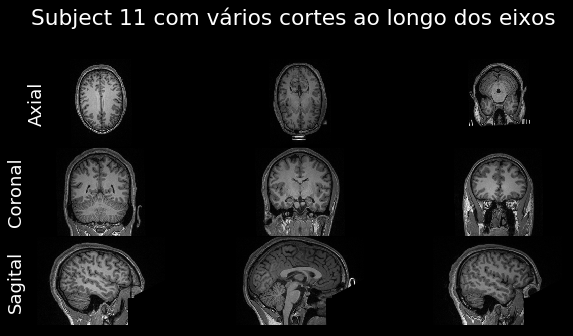

In [33]:
# Lendo a imagem de um paciente saudável

sub11, sub11_raw = load_nii('../data/anat/sub-11_anat_sub-11_T1w.nii.gz')

plot_bolacha(sub11, title="Subject 11 com vários cortes ao longo dos eixos", bolachas=3)

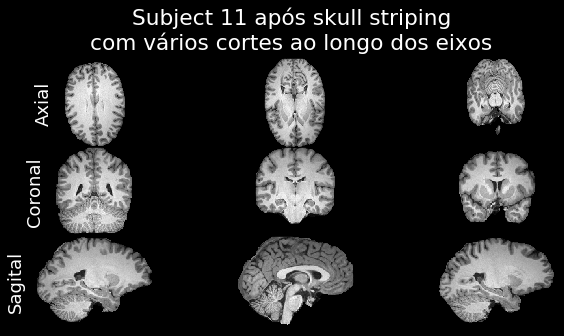

In [35]:
# Estraindo o cérebro

ext = Extractor()

# prob é uma imagem representando a probabilidade de cada voxel 
# ser do cérebro
prob = ext.run(sub11) 

# Obtendo e aplicando a máscara
mask = prob < 0.5
sub11[mask] = 0

# Cortando a imagem nas bordas
sub11 = cut_on_edges(sub11)

plot_bolacha(sub11, title="Subject 11 após skull striping\ncom vários cortes ao longo dos eixos", bolachas=3)

picos encontrados: [62 97]


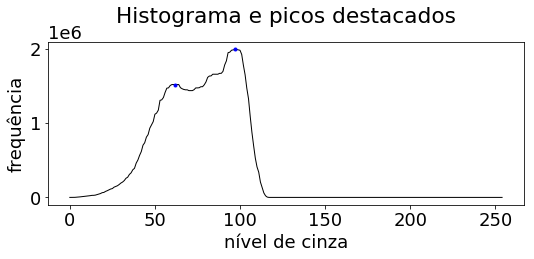

In [37]:
sub = np.copy(sub0)

# Suavizando a imagem
for i in range(sub.shape[0]):
    sub[i,:,:] = cv2.medianBlur(sub[i,:,:],3).astype('uint8')

for i in range(sub.shape[1]):
    sub[:,i,:] = cv2.medianBlur(sub[:,i,:],3).astype('uint8')

for i in range(sub.shape[2]):
    sub[:,:,i] = cv2.medianBlur(sub[:,:,i],3).astype('uint8')
    

# Obtendo o histograma, descartando o zero e filtrando
hist = myhist(sub)
hist = hist[1:]
hist = medfilt(hist, 7)

# Encontrando os picos
peaks, _ = find_peaks(hist, height=500000)

print('picos encontrados:', peaks)

# Plotando o histograma e os picos
fig, axs = plt.subplots(figsize=(8, 4))

axs.plot(hist, lw=1, c='k')
axs.plot(peaks, hist[peaks], ".b")

axs.set_xlabel('nível de cinza')
axs.set_ylabel('frequência')
axs.set_title('Histograma e picos destacados', y=1.08)

axs.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')

plt.tight_layout()
plt.show()

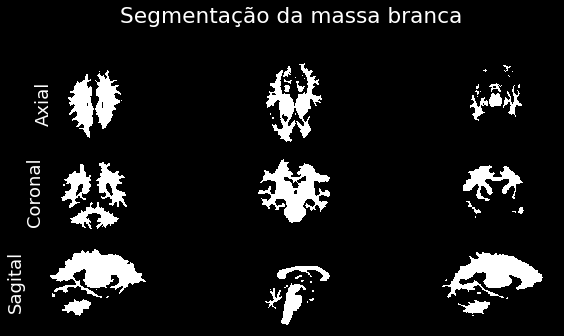

In [38]:
# Utilizando o último pico para segmentar a massa branca

margin = 10

threshold = peaks[-1]

sub_white = np.copy(sub)

sub_white[sub_white<threshold-margin] = 0
sub_white[sub_white>0] = 255

plot_bolacha(sub_white, title="Segmentação da massa branca", bolachas=3)

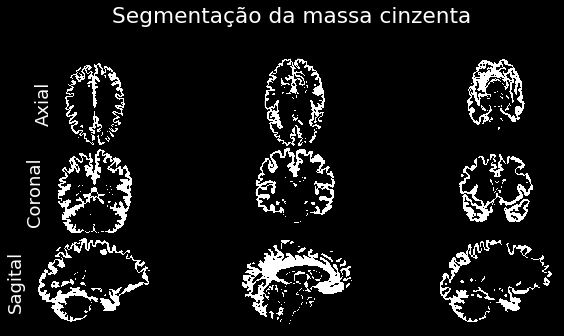

In [39]:
# Analogamente para a massa cinzenta

threshold = peaks[0]

sub_gray = np.copy(sub)
sub_gray[sub_gray>threshold+margin] = 0
sub_gray[sub_gray<threshold-margin] = 0
sub_gray[sub_gray>0] = 255

plot_bolacha(sub_gray, title="Segmentação da massa cinzenta", bolachas=3)

## Sumarização e criação da rotina de pré processamento

Agora que foram criadas funções auxiliares e investigado o processo de limearização para segmentação de massa branca e cinzenta, vamos criar um método que faça todo esse processo de forma automática, para ser utilizado por um script na preparação de uma base de dados com informações de tecidos.

Em uma imagem de ressonância temos 3 tecidos:
1. __Massa branca__, que corresponde às conexões dos neurônios. Sua coloração se dá pois os axônios costumam ser envolvidos pela bainha de mielina, um revestimento criado pelos oligodendrócitos que aumenta a velocidade de propagação de potenciais de ação. Esse revestimento acaba apresentando uma cor mais clara e, macroscopicamente, vemos regiões com alta concentração de conexões com uma coloração mais esbranquiçada;
2. __Massa cinzenta__, que corresponde aos corpos celulares dos neurônios (chamados de soma). Geralmente, no cérebro, temos regiões corticais (que são aquelas com sulcos e giros), onde ficam os corpos neuronais. Então, na superfície de todo o telencéfalo, temos uma concentração de somas, que possuem uma coloração cinza.
3. __Líquido cefalorraquidiano__, que é produzido pelo plexo coróide, localizado principalmente nos ventrículos laterais, e é um fluido que circula no espaço interno do sistema nervoso central. o nível de cinza desse líquido é próximo de zero, e dificilmente é notado visualmente. Por ser um líquido que ocupa o espaço interno e preenche os ventrículos (ventrículos laterais, terceiro e quarto ventrículo), sua segmentação permite ter uma noção das dimensões dos ventrículos.

De forma análoga como foi feita a segmentação da massa branca e massa cinzenta, podemos fazer a segmentação do líquido cefalorraquidiano.

Combinando todas as etapas anteriormente apresentadas, podemos definir a seguinte função:

[68 82 91]


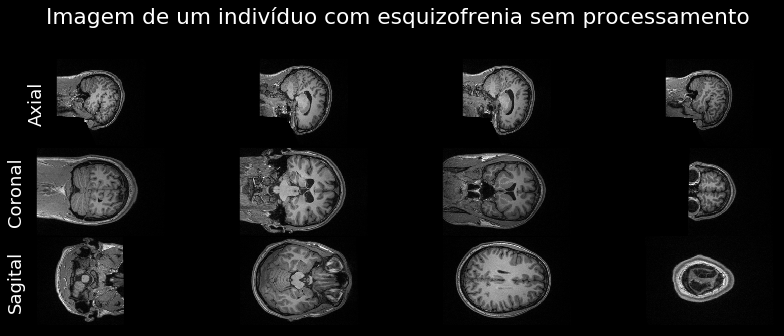

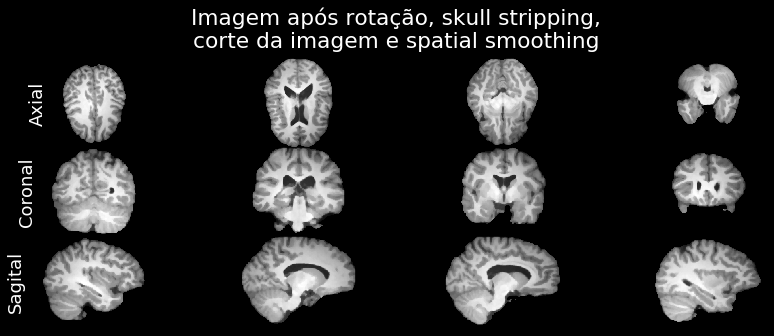

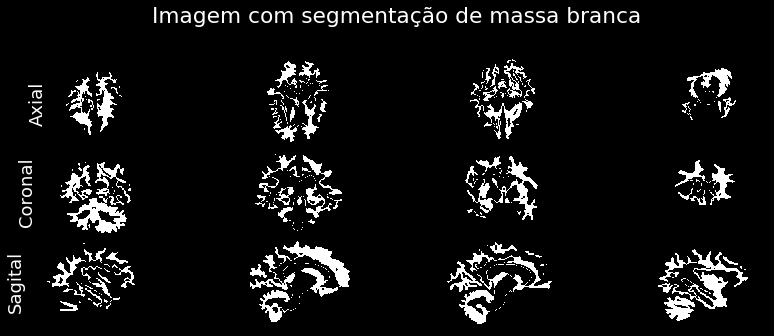

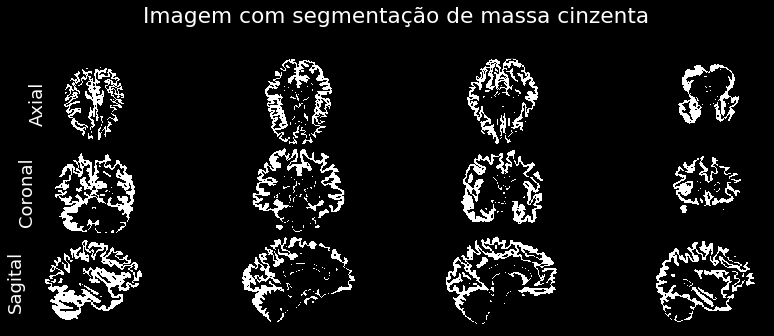

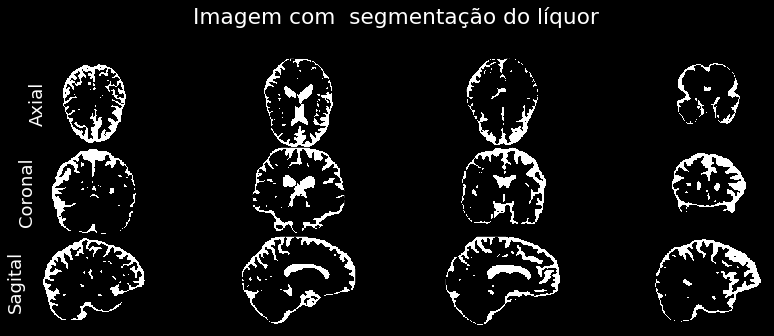

In [44]:
fixed_size = 127

def preprocess(path):
    
    sub, sub_raw = load_nii(path)

    ext = Extractor()

    prob = ext.run(sub) 

    mask = prob < 0.5
    sub[mask] = 0

    sub = cut_on_edges(sub)


    for i in range(sub.shape[0]):
        sub[i,:,:] = cv2.medianBlur(sub[i,:,:],3).astype('uint8')

    for i in range(sub.shape[1]):
        sub[:,i,:] = cv2.medianBlur(sub[:,i,:],3).astype('uint8')

    for i in range(sub.shape[2]):
        sub[:,:,i] = cv2.medianBlur(sub[:,:,i],3).astype('uint8')

    sub_white = np.copy(sub)
    sub_gray  = np.copy(sub)
    sub_csf   = np.copy(sub)
    
    hist = myhist(sub)
    hist = hist[1:]
    hist = medfilt(hist, 7)
    
    peaks, _ = find_peaks(hist, height=500000)

    print(peaks)
    
    margin = 10
    
    threshold = peaks[-1]    
    sub_white[sub_white>threshold+margin] = 0
    sub_white[sub_white<threshold-margin] = 0
    sub_white[sub_white>0] = 255
    
    threshold = peaks[0]
    sub_gray[sub_gray>threshold+margin] = 0
    sub_gray[sub_gray<threshold-margin] = 0
    sub_gray[sub_gray>0] = 255
    
    sub_csf[sub_csf>threshold-margin] = 0
    sub_csf[sub_csf>0] = 255
    
    
    common = sub_csf * sub_white * sub_gray

    sub_gray = sub_gray - common    
    sub_gray[sub_gray<0] = 0

    sub_white = sub_white - common    
    sub_white[sub_white<0] = 0
    
    sub_csf = sub_csf - common    
    sub_csf[sub_csf<0] = 0

    
    return sub_raw, sub, sub_white, sub_gray, sub_csf


# Exemplo de uso ---------------------------
sub_raw, sub, sub_white, sub_gray, sub_csf = preprocess('../data/anat/sub-09_anat_sub-09_T1w.nii.gz')

plot_bolacha(sub_raw,   title="Imagem de um indivíduo com esquizofrenia sem processamento", bolachas=4)
plot_bolacha(sub,       title="Imagem após rotação, skull stripping,\ncorte da imagem e spatial smoothing", bolachas=4)
plot_bolacha(sub_white, title="Imagem com segmentação de massa branca", bolachas=4)
plot_bolacha(sub_gray,  title="Imagem com segmentação de massa cinzenta", bolachas=4)
plot_bolacha(sub_csf,   title="Imagem com  segmentação do líquor", bolachas=4)